In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
encoding = 'latin1'  # Change to the appropriate encoding if needed
df = pd.read_csv("SeoulBikeData.csv", encoding = encoding)

# This is the data from UC Irvine Machine Learning Data Set. 
# Data from 2017 to 2018, Number of Bike Rented, and other relevant data.

In [4]:
# Let's look at how the data looks like. 
df.head(5)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


<AxesSubplot:>

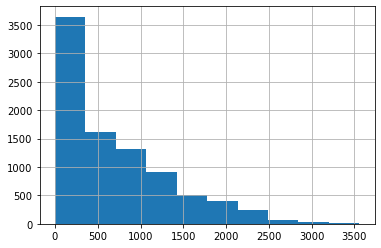

In [5]:
df["Rented Bike Count"].hist()

# Let us explore the data. First, we see multiple data points for the same date, so we have to work on this.

In [7]:
df[df["Date"]=='01/12/2017'].head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## We have rented bike count per each hour starting at 0 and ending at 23. To make it smooth, what we do is to apply sin.

In [8]:
df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)

## It is obvious that the demand is higher during the commute, and after work during the weekdays.

In [10]:
# NO Holiday, and commute hours + after work = peak

df["morning"] = np.where((df["Hour"].isin([5,6,7,8,9])),1,0)
df["afternoon"] = np.where((df["Hour"].isin([12,13,14,15,16])),1, 0)
df["evening"] = np.where((df["Hour"].isin([17, 18, 19, 20, 21, 22])),1, 0)
df["peak"] = np.where((df["evening"]==1)&(df["Holiday"]=="No Holiday"), 1, 0)

## It is surprising that Bike count is lower in holidays. 

In [13]:
df.groupby(["Holiday"])["Rented Bike Count"].mean()

Holiday
Holiday       499.756944
No Holiday    715.228026
Name: Rented Bike Count, dtype: float64

In [14]:
df["humtemp"] = df["Humidity(%)"]*df["Temperature(°C)"]
df["hourhum"] = df["humtemp"] * df["hour_sin"]

## Let's draw a heatmap

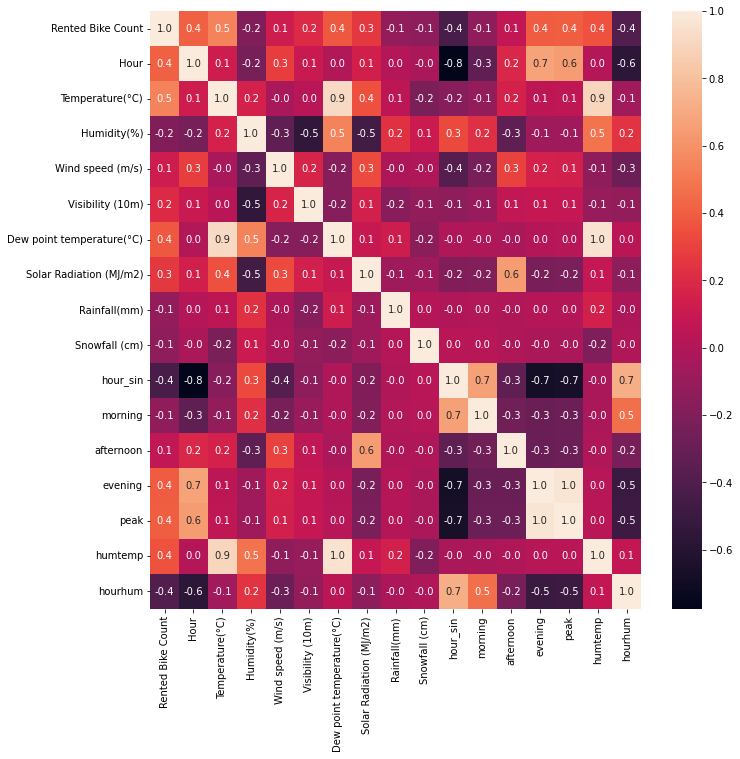

In [18]:
corr = df.corr()
plt.figure(figsize=(11, 11))  # Set the figure size
sns.heatmap(corr, annot=True, fmt='.1f')  # Create the heatmap
plt.show()  # Display the plot

## Our target variable is stronglycorrelated with "Hour", "Temperature", "Dew Point Temperature", "Solar Radiation"

## Rainfall and Snowfall seem to have low correlation, but we have to see if that is actually the case.

In [19]:
# Create columns whether there was any snowfall or rainfall

df["snow"] = np.where(df["Snowfall (cm)"]>0, 1, 0)
df["rain"] = np.where(df["Rainfall(mm)"]>0, 1, 0)

# Calculate the correlations

print("correlation between snowfall and rentedbike:",round(df["Rented Bike Count"].corr(df["snow"]),2) )
print("correlation between rainfall and rentedbike:",round(df["Rented Bike Count"].corr(df["rain"]),2))

correlation between snowfall and rentedbike: -0.19
correlation between rainfall and rentedbike: -0.21


## Dewpoint Temperature is strongly correlated with the number of rented bikes. However, it may come from the fact that it is correlated with the temperature strongly.

## Dewpoint temperature itself does not mean anything. Rather, it is important to know the deviation from this dewpoint temperature.

In [23]:
# Difference between the current temperature and dew point temperature(ideal) 
df["temp_diff"] = df["Temperature(°C)"]-df["Dew point temperature(°C)"] 


## Also, moving average of temperature may matter because you decide to ride a bike and then it takes a few hours to actually ride it.


In [24]:
window_size = 3


df['temp_rolling_avg'] = df['Temperature(°C)'].rolling(window=window_size).mean()
df['temp_rolling_avg'].fillna(df['Temperature(°C)'], inplace =True)

df.fillna(df.median, inplace= True)

In [26]:
# We see whether there is any null values

print(df.isnull().sum())
print("WE do not see any null values")

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
hour_sin                     0
morning                      0
afternoon                    0
evening                      0
peak                         0
humtemp                      0
hourhum                      0
snow                         0
rain                         0
temp_diff                    0
temp_rolling_avg             0
dtype: int64
WE do not see any null values


# Get dummy variables for season

In [47]:
df['Holiday'] = df['Holiday'].map({'Holiday': 1, 'No Holiday': 0})  # Adjust the mapping as per your data
df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})  # Adjust the mapping as per your data

# Apply one-hot encoding to 'Seasons' and keep the binary-encoded 'Holiday' and 'Functioning Day'
df_dummies = pd.get_dummies(df, columns=['Seasons'])

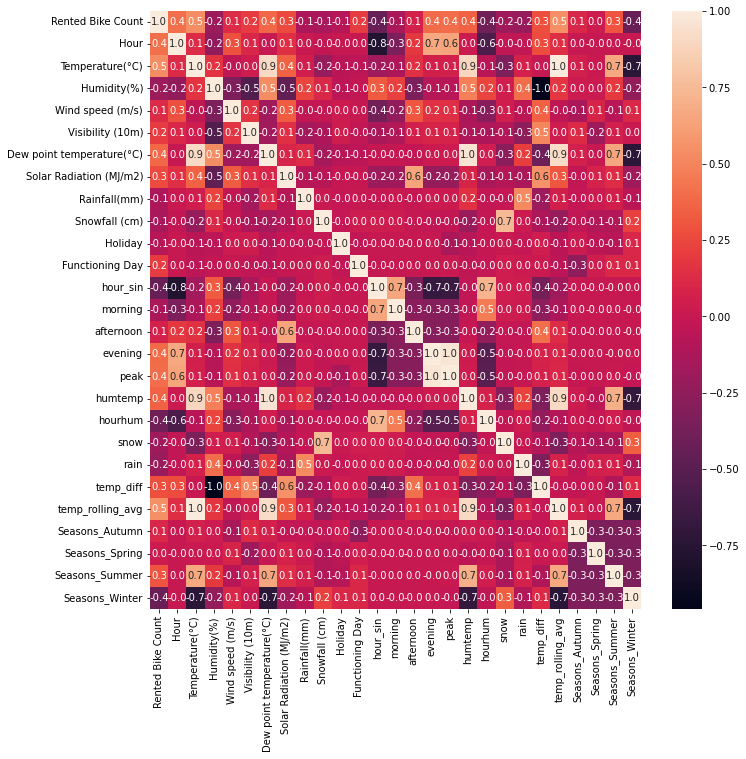

In [48]:
# Let's look at the heatmap again with our feature engineered data set.

corr_new = df_dummies.corr()
plt.figure(figsize = (11, 11))
sns.heatmap(corr_new, annot =True, fmt = '.1f')
plt.show()

## Let us do a simple regression study first as a benchmark

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

y = df_dummies["Rented Bike Count"]
X = df_dummies.drop(["Rented Bike Count", "Date"], axis =1 )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 111)
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(pred, y_test)
print(mae)

279.5438236614781


## The reason why I use MAE instead of MSE is that we have long tail, so I do not want my result to bd depenedent too much on the outlier.

In [50]:
linear_coef = pd.DataFrame(model.coef_, index = X.columns, columns = ["Coefficient"])
linear_coef

,Coefficient
Hour,3.659360
Temperature(°C),3.210452
Humidity(%),-3.508266
Wind speed (m/s),-1.748407
Visibility (10m),0.001979
Dew point temperature(°C),0.359581
Solar Radiation (MJ/m2),67.942851
Rainfall(mm),-15.368366
Snowfall (cm),-33.457308
Holiday,-72.469367


## Seasons Autumn, Winter matter. Whether it is functioning or not matters. Hour, and Peak, Snow, Rain also matters. 

## Then, let us try Lasso. 

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 111, test_size = 0.2)

lasso = Lasso(alpha = 3.0)
lasso.fit(X_train,y_train)
lasso_coef = pd.DataFrame(lasso.coef_, index = X.columns, columns = ["Coefficient"])
lasso_coef

/Users/wsyoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 462108893.0645845, tolerance: 289527.95167487167
  model = cd_fast.enet_coordinate_descent(


,Coefficient
Hour,6.489470
Temperature(°C),11.924957
Humidity(%),-3.963241
Wind speed (m/s),0.000000
Visibility (10m),0.005757
Dew point temperature(°C),0.000000
Solar Radiation (MJ/m2),32.850861
Rainfall(mm),-20.353907
Snowfall (cm),0.000000
Holiday,-10.772213


## Feature Selection & Prediction Error

In [68]:
select = lasso_coef[lasso_coef.Coefficient>0]

In [59]:
pred =lasso.predict(X_test)
mae_lasso = mean_absolute_error(pred, y_test)
print("mean absolute error for lasso with alpha = 3:",mae_lasso)

mean absolute error for lasso with alpha = 3: 278.6512759853782


## Not Very Satisfactory, the prediction error did not improve that much using Lasso. ##

## Let us move on to RandomForest and GradientBoosting

In [61]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
mae_rf = mean_absolute_error(pred, y_test)
print("mean absolute error for a naive rf:", mae_rf)

mean absolute error for a naive rf: 150.03055936073062


In [62]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
mae_gb = mean_absolute_error(pred, y_test)
print("mean absolute error for a naive gb:", mae_gb)

mean absolute error for a naive gb: 178.02963109196546


## Even the naive random forest or gradient boosting are way better than lasso. But let's do some fine tuning!

In [64]:
from sklearn.pipeline import make_pipeline
pipelines = {
    'rf': make_pipeline(StandardScaler(), RandomForestRegressor(random_state = 111) ),
    'gb': make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state =111))
}
rf_hp = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33],
    'randomforestregressor__min_samples_leaf': [1, 3, 5, 10],
}

gb_hp ={
    'gradientboostingregressor__n_estimators': [100, 200],
    'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}

hyperparameters = {
    'rf' : rf_hp,
    'gb' : gb_hp
}


In [65]:
from sklearn.model_selection import GridSearchCV
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv = 10, n_jobs = -1, scoring = 'neg_mean_absolute_error')
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted')

for name in fitted_models:
    print(name, fitted_models[name].best_score_)

rf has been fitted
gb has been fitted
rf -139.71020476665984
gb -140.734165367745


In [73]:
df["Rented Bike Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Rented Bike Count, dtype: float64

## If you compare our MAE with the std of the bike count, the prediction seems efficient.

## What if we use the feature selection results from Lasso. 

In [74]:
X_s = X[select.index]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, random_state = 111, test_size = 0.2)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
mae_rf = mean_absolute_error(pred, y_test)
print("mean absolute error for a naive rf:", mae_rf)

mean absolute error for a naive rf: 159.63615296803655


In [ ]:
# Not working well. Random Forest Regressor is already efficient, so it may not be a good idea to select t